# Simulation for Optimization examples


In [283]:

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# you may not use them directly, stats.binom is suggested.
from scipy.stats import poisson, rv_discrete, binom, rv_discrete, norm, halfnorm

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)


## Problem 1

### You operate an aircraft that flies two flights per day: an "outbound" flight from its base to a remote destination, and then and "inbound" flight back again. The aircraft can carry a mix of passengers and freight:

### If configured for all passengers, the aircraft holds 216 seats. Each freight pallet you configure the aircraft to hold takes away 24 seats, and you are considering setting up the aircraft to hold 0, 1, 2, 3, 4, 5, or 6 freight pallets. The split between seats and space for pallets must be decided once a year when the aircraft undergoes "heavy maintenance"; it cannot be changed for each flight.

### You make a profit of $50 for each passenger carried (in either direction), and demand for seats on the outbound flight is Poisson with a mean of 160, while demand for seats on the inbound flight is Poisson with a mean of 159 (independent of the outbound flight). Demand for freight carriage is independent of passenger demand and also independent between the inbound and outbound flights.(See Pallet_Table).You make a profit $275 per pallet carried (in either direction). What aircraft configuration maximizes the average profit per day?

<style>
table
{
    margin: auto;
}
</style>


|num  | outbound_pallets_prob|   inbound_pallets_prob |
|:--:|:--:|:--:|
| 0                     | 0.06                 | 0.07 |
| 1                     | 0.08                 | 0.09 |
| 2                     | 0.18                 | 0.18 |
| 3                     | 0.20                 | 0.19 |
| 4                     | 0.21                 | 0.17 |
| 5                     | 0.16                 | 0.16 |
| 6                     | 0.11                 | 0.14 |


### Set the parameters of the problem and generate the random variables


In [245]:
N = 10000  # set the number of trials
n = (0, 1, 2, 3, 4, 5, 6)  # number of pallets considered

# seats_capacity = 216
# taken_by_each_pallet = 24
# passenger_profit = 50 / seat
# pallet_profit = 275 / pallet


In [246]:
# Create the pallets_Table for inboud and outbound demand discrete probability
pallets_table = pd.DataFrame(
    {
        'outbound_pallets_prob': [0.06, 0.08, 0.18, 0.2, 0.21, 0.16, 0.11],
        'inbound_pallets_prob': [0.07, 0.09, 0.18, 0.19, 0.17, 0.16, 0.14]
    },
    index=n)
pallets_table


,outbound_pallets_prob,inbound_pallets_prob
0,0.06,0.07
1,0.08,0.09
2,0.18,0.18
3,0.20,0.19
4,0.21,0.17
5,0.16,0.16
6,0.11,0.14


In [247]:
# genenerate the inbound and outbound demand random variables

demand_pal_out_rvs = stats.rv_discrete(
    name='Pal_Out_rvs',
    values=(n, pallets_table['outbound_pallets_prob'])).rvs(size=N)

demand_pal_in_rvs = stats.rv_discrete(
    name='Pal_In_rvs',
    values=(n, pallets_table['inbound_pallets_prob'])).rvs(size=N)


In [248]:
# Generate seats demand random variables

mu_out = 160  # demand for seats on the outbound flight is Poisson with a mean of 160

mu_in = 159  # demand for seats on the inbound flight is Poisson with a mean of 159

demand_seats_out_rvs = stats.poisson(mu_out).rvs(size=N)
demand_seats_in_rvs = stats.poisson(mu_in).rvs(size=N)


### Considering setting up the aircraft to hold 0, 1, 2, 3, 4, 5, or 6 freight pallets


In [249]:
# When there is 0 freight pallet in the plane.
# Pallets sale = min(demand_pallets and 0),thus:

pallets_out_sale = 0
pallets_in_sale = 0


In [250]:
# number_of_seats_In_and_Out_available = seats_capacity = 216
seats_out_sale = np.minimum(demand_seats_out_rvs, np.ones(N) * 216)
seats_in_sale = np.minimum(demand_seats_in_rvs, np.ones(N) * 216)


In [251]:
profit_Out = seats_out_sale * 50
profit_In = seats_in_sale * 50

profit_total = profit_Out + profit_In
mean_profit_0 = np.mean(profit_total)

print(
    f"When there is 0 freight pallet in the plane.\nthe mean of the profit is {mean_profit_0}"
)


When there is 0 freight pallet in the plane.
the mean of the profit is 15950.37


In [252]:
# Create simulation function for the mean profit of each scenario from 1 to 6 pallets


def mean_profit(i, seats_capacity=216):
    """Simulate the actuall sales of pallets and seats numbers for each scenario,where i = numbers of palltes"""

    pallets_out_sale = np.minimum(demand_pal_out_rvs, np.ones(N) * i)
    pallets_in_sale = np.minimum(demand_pal_in_rvs, np.ones(N) * i)

    # Next, calculate the available seats left for passengers:
    seats_out_available = seats_capacity - pallets_out_sale * 24
    seats_out_sale = np.minimum(demand_seats_out_rvs, seats_out_available)

    seats_in_available = seats_capacity - pallets_in_sale * 24
    seats_in_sale = np.minimum(demand_seats_in_rvs, seats_in_available)
    """calculate the profit"""
    profit_out = seats_out_sale * 50 + pallets_out_sale * 275
    profit_in = seats_in_sale * 50 + pallets_in_sale * 275

    profit_total = profit_out + profit_in
    return np.mean(profit_total).astype(int)


When there are 0 pallets in the plane:
    The mean of the profit is $15950.
When there are 1 pallets in the plane:
    The mean of the profit is $16462.
When there are 2 pallets in the plane:
    The mean of the profit is $16770.
When there are 3 pallets in the plane:
    The mean of the profit is $16183.
When there are 4 pallets in the plane:
    The mean of the profit is $15339.
When there are 5 pallets in the plane:
    The mean of the profit is $14815.
When there are 6 pallets in the plane:
    The mean of the profit is $14582.


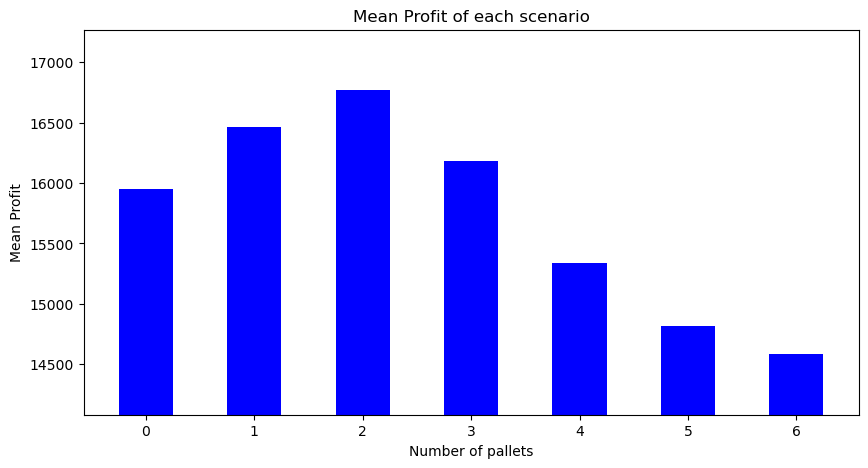

In [253]:
result_profits = np.empty(shape=(7, 1), dtype=int)

_, ax = plt.subplots(figsize=(10, 5))

for i in range(7):
    result_profits[i] = mean_profit(i)

    print(
        f"When there are {i} pallets in the plane:\n    The mean of the profit is ${mean_profit(i).round(2)}."
    )
    ax.bar(i, result_profits[i], color='blue', width=0.5)
    ax.set(title='Mean Profit of each scenario',
           xlabel='Number of pallets',
           ylabel='Mean Profit',
           ylim=(np.min(result_profits) - 500, np.max(result_profits) + 500))


In [254]:
print(
    f"\nHence the highest profit is ${np.max(result_profits)},when there are {np.argmax(result_profits)} pallets assembeld in the plane."
)



Hence the highest profit is $16770,when there are 2 pallets assembeld in the plane.


## Problem 2

### You run a newspaper stand. You cannot predict exactly how many copies of the Daily Blab newspaper you will be able to sell, but in the past, you have observed the following demand pattern:

<style>
table
{
    margin: auto;
}
</style>

|Demand|Percentage of the Time|
|:-:|:-:|
| 20 | 1% |
| 21 | 2% |
| 22 | 3% |
| 23 | 4% |
| 24 | 5% |
| 25 | 6% |
| 26 | 6% |
| 27 | 7% |
| 28 | 7% |
| 29 | 7% |
| 30 | 7% |
| 31 | 7% |
| 32 | 7% |
| 33 | 6% |
| 34 | 5% |
| 35 | 4% |
| 36 | 4% |
| 37 | 3% |
| 38 | 3% |
| 39 | 3% |
| 40 | 3% |

#### Each copy of the Daily Blab costs you $0.35 and sells for $0.45. You must place your order for the papers the night before they are sold, before you know exactly how many copies you will be able to sell. Unsold copies may be returned to the publisher at the end of the day for a credit of $0.05 each. You can buy the paper only in multiples of 5, and are considering stocking either 20, 25, 30, 35, or 40 papers per day. What is the right number of papers to order each night?


In [255]:
n = np.arange(20, 41)

percent_demand = pd.DataFrame(
    [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.06, 0.07, 0.07, 0.07, 0.07, 0.07,
     0.07, 0.06, 0.05, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03
     ], index=n)


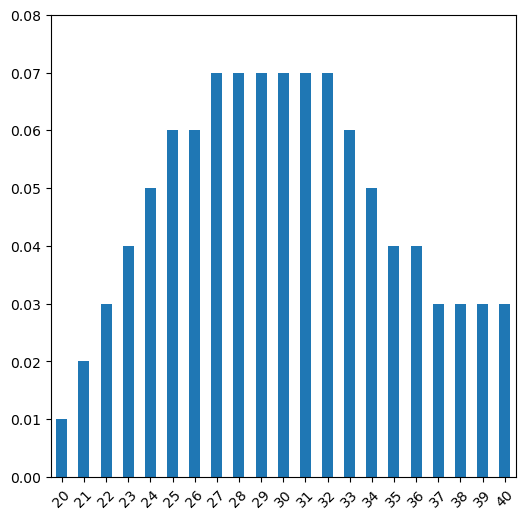

In [256]:
_, ax = plt.subplots(figsize=(6, 6))

percent_demand.plot.bar(ax=ax)

ax.set(ylim=(0, 0.08))
ax.set_xticklabels(percent_demand.index, rotation=45)

plt.legend().remove()
plt.show()


In [257]:
N = 10000 # number of trials


In [258]:
news_rvs = rv_discrete(name='news_rvs',
                       values=(n, percent_demand[0])).rvs(size=N)

news_20 = news_rvs[news_rvs == 20]
news_25 = news_rvs[news_rvs <= 25]
news_30 = news_rvs[news_rvs <= 30]
news_35 = news_rvs[news_rvs <= 35]
news_40 = news_rvs


In [259]:
profit_20 = news_20 * 0.45 - 20 * 0.35
profit_25 = news_25 * 0.45 - 25 * 0.35 + (25 - news_25) * 0.05
profit_30 = news_30 * 0.45 - 30 * 0.35 + (30 - news_30) * 0.05
profit_35 = news_35 * 0.45 - 35 * 0.35 + (35 - news_35) * 0.05
profit_40 = news_40 * 0.45 - 40 * 0.35


In [260]:
means = []

for profit in (profit_20, profit_25, profit_30, profit_35, profit_40):
    means.append(np.mean(profit))
    print(round(profit.mean(), 4))


2.0
1.8355
1.5234
0.9199
-0.5004


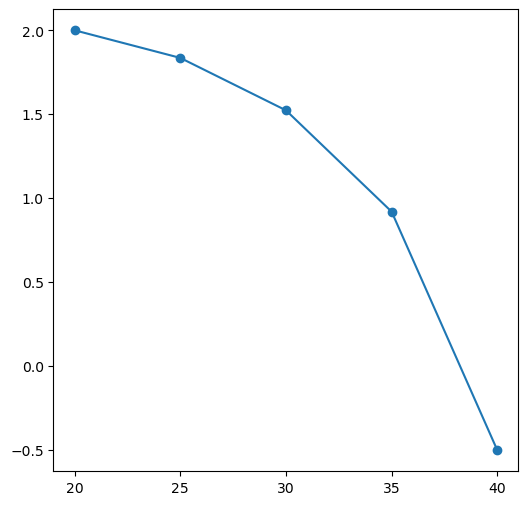

In [261]:
_, ax = plt.subplots(figsize=(6, 6))

plt.plot(means, 'o-')

ax.set_xticks(range(len(means)))
ax.set_xticklabels(['20', '25', '30', '35', '40'])

plt.show()


## Ans:

### We should order 20 newspapers each night to make the mean profit by 2 dollars.


## Problem 3

You are taking reservations for an airline flight. This particular flight uses an aircraft with 50 first- class seats and 190 economy-class seats.

First-class tickets on the flight cost $600, with demand to purchase them distributed like a Poisson random variable with mean 50. Each passenger who buys a first-class ticket has a 93% chance of showing up for the flight. If a first-class passenger does not show up, he or she can return their unused ticket for a full refund. Any first class passengers who show up for the flight with tickets but are denied boarding are entitled to a full refund plus a $500 inconvenience penalty.

Economy tickets cost $300. Demand for them is Poisson distributed with a mean of 200, and is independent of the demand for first-class tickets. Each ticket holder has a 96% chance of showing up for the flight, and "no shows" are not entitled to any refund. If an economy ticket holder shows up and is denied a seat, however, they get a full refund plus a $200 penalty. If there are free seats in first class and economy is full, economy ticket holders can be seated in first class.

The airline allows itself to sell somewhat more tickets than it has seats. This is a common practice called "overbooking". The firm is considering the 18 possible polices obtained through all possible combinations of:

- Allowing overbooking of up to 0, 5, or 10 first-class seats
- Allowing overbooking of up to 0, 5, 10, 15, 20, or 25 economy seats

1. Which option gives the highest average profit?
2. What are the average numbers of first-class and economy passengers denied seating under this policy.
3. If no overbooking of first class is allowed, what is the best policy?


## Part3-Problem 1

### You make a perishable, volatile chemical for which you charge $2.25 per liter.

You have 75 regular customers for the chemical, each of whom has an independent 90% chance of placing an order on any given day. You also get an average of 30 orders per day from other, non-regular customers; assume the number of non-regular customers per day has a Poisson distribution.

Every order is for one 20-liter container. You produce the chemical by a process that produces 600 liters of the chemical at a cost of $1300.

Each day, you can run the process any whole number of times. Because it is so unstable, any chemical left unsold at the end of the day must be recycled, at a cost of $0.35 per liter.

What is the best number of times to run the process?

     Consider four possible policies of running the process 1, 2, 3 or 4 times.


### Define the scenarios

In [262]:
# produce the chemical by a process that produces 600 liters of the chemical at a cost of $1300.
# Consider four possible policies of running the process 1, 2, 3 or 4 times.
# The process is described by the following dictionaries:
scen_param = {
    1: (600, 1300),
    2: (1200, 2600),
    3: (1800, 3900),
    4: (2400, 5200)
}


In [263]:
class chemSim:
    """simulate the chemical producing process for 100 days
    where : scen_param = { 1:(600, 1300), 2:(1200, 2600), 3:(1800, 3900), 4:(2400, 5200)}
    """

    def __init__(self, scen_param):
        self.days = 100
        self.scen_param = {
            1: (600, 1300),
            2: (1200, 2600),
            3: (1800, 3900),
            4: (2400, 5200)
        }

    def chem_df(self, i):
        regular_order = stats.binom(n=75, p=0.9).rvs(size=self.days)
        # 75 regular customers for the chemical, each of whom has an independent 90% chance of placing an order on any given day.

        non_regular_order = stats.poisson(mu=30).rvs(
            size=self.days
        )  # an average of 30 orders per day from other, non-regular customers

        chem_prod_sim_df = pd.DataFrame({
            'regular_L': regular_order * 20,
            'non_regular_L': non_regular_order * 20,
            'left_cost': np.zeros(self.days),
            'produce': self.scen_param[i][0],
            'cost': self.scen_param[i][1],
            'sale': np.zeros(self.days)
        })  # Create the simulation dataframe

        # analyze the demand and the production of the chemical:
        chem_prod_sim_df_1 = chem_prod_sim_df.copy()
        # if the demand is greater than the production,all the chemicals will be sold in the end.
        chem_prod_sim_df_1.query(expr='regular_L + non_regular_L > produce',
                                 inplace=True)
        chem_prod_sim_df_1['sale'] = chem_prod_sim_df_1['produce'] * 2.25

        chem_prod_sim_df_2 = chem_prod_sim_df.copy()
        # if the demand is less than the production, there will be unsold chemicals which need to be handled in the end, the recycle fee should be considered.
        chem_prod_sim_df_2.query(expr='regular_L + non_regular_L <= produce',
                                 inplace=True)
        # actuall sale of the chemicals
        chem_prod_sim_df_2['sale'] = (
            chem_prod_sim_df_2['regular_L'] +
            chem_prod_sim_df_2['non_regular_L']) * 2.25

        # the recycle fee for the chemical left:
        chem_prod_sim_df_2['left_cost'] = (
            chem_prod_sim_df_2['produce'] -
            (chem_prod_sim_df_2['regular_L'] +
             chem_prod_sim_df_2['non_regular_L'])) * 0.35

        # combine the two dataframes of codndiditons together.
        chem_prod_sim_df = pd.concat([chem_prod_sim_df_1, chem_prod_sim_df_2])
        chem_prod_sim_df['profit'] = chem_prod_sim_df['sale'] - (
            chem_prod_sim_df['cost'] + chem_prod_sim_df['left_cost'])

        return chem_prod_sim_df


#### Simulate the process for each of the four policies for 100 days:


In [264]:
# 1 time of the producing proces in 100 days.
chemSim(1).chem_df(1)


,regular_L,non_regular_L,left_cost,produce,cost,sale,profit
0,1400,640,0.0,600,1300,1350.0,50.0
1,1360,580,0.0,600,1300,1350.0,50.0
2,1220,700,0.0,600,1300,1350.0,50.0
3,1280,700,0.0,600,1300,1350.0,50.0
4,1380,400,0.0,600,1300,1350.0,50.0
...,...,...,...,...,...,...,...
95,1340,640,0.0,600,1300,1350.0,50.0
96,1420,480,0.0,600,1300,1350.0,50.0
97,1340,740,0.0,600,1300,1350.0,50.0
98,1320,580,0.0,600,1300,1350.0,50.0


In [265]:
# 2 times of the producing proces in 100 days.
chemSim(2).chem_df(2)


,regular_L,non_regular_L,left_cost,produce,cost,sale,profit
0,1320,680,0.0,1200,2600,2700.0,100.0
1,1360,440,0.0,1200,2600,2700.0,100.0
2,1320,660,0.0,1200,2600,2700.0,100.0
3,1400,560,0.0,1200,2600,2700.0,100.0
4,1340,560,0.0,1200,2600,2700.0,100.0
...,...,...,...,...,...,...,...
95,1380,540,0.0,1200,2600,2700.0,100.0
96,1460,440,0.0,1200,2600,2700.0,100.0
97,1400,400,0.0,1200,2600,2700.0,100.0
98,1360,580,0.0,1200,2600,2700.0,100.0


In [266]:
# 3 times of the producing proces in 100 days.
chemSim(3).chem_df(3)


,regular_L,non_regular_L,left_cost,produce,cost,sale,profit
0,1300,700,0.0,1800,3900,4050.0,150.0
1,1380,640,0.0,1800,3900,4050.0,150.0
2,1400,620,0.0,1800,3900,4050.0,150.0
3,1380,700,0.0,1800,3900,4050.0,150.0
4,1280,620,0.0,1800,3900,4050.0,150.0
...,...,...,...,...,...,...,...
60,1380,320,35.0,1800,3900,3825.0,-110.0
75,1340,460,0.0,1800,3900,4050.0,150.0
77,1360,440,0.0,1800,3900,4050.0,150.0
92,1340,460,0.0,1800,3900,4050.0,150.0


In [267]:
# 4 times of the producing proces in 100 days.
chemSim(4).chem_df(4)


,regular_L,non_regular_L,left_cost,produce,cost,sale,profit
0,1280,640,168.0,2400,5200,4320.0,-1048.0
1,1380,480,189.0,2400,5200,4185.0,-1204.0
2,1280,780,119.0,2400,5200,4635.0,-684.0
3,1340,460,210.0,2400,5200,4050.0,-1360.0
4,1360,680,126.0,2400,5200,4590.0,-736.0
...,...,...,...,...,...,...,...
95,1320,660,147.0,2400,5200,4455.0,-892.0
96,1400,480,182.0,2400,5200,4230.0,-1152.0
97,1420,720,91.0,2400,5200,4815.0,-476.0
98,1340,640,147.0,2400,5200,4455.0,-892.0


The mean proifts of each scenatio is:[[  50]
 [ 100]
 [ 136]
 [-945]]

So,if there are 1 times of running the process,the highest profit is $4404080440.


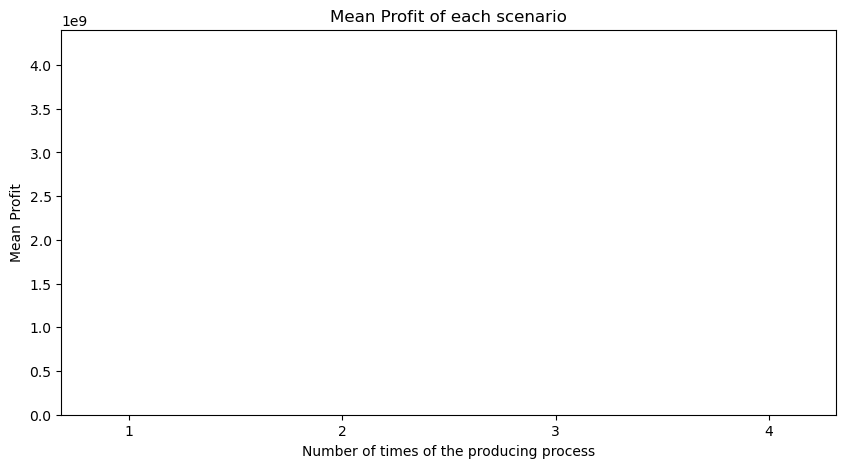

In [268]:
result_Mean_profits = np.empty(shape=(5, 1), dtype=int)

_, ax = plt.subplots(figsize=(10, 5))

for i in range(1, 5):
    result_Mean_profits[i] = np.mean(chemSim(i).chem_df(i)['profit'])

    ax.bar(i, result_Mean_profits[i], color='blue', width=0.3)
    ax.set(ylim=(np.min(result_Mean_profits) - 100,
                 np.max(result_Mean_profits) + 100),
           xticks=np.arange(1, 5),
           xticklabels=['1', '2', '3', '4'],
           title='Mean Profit of each scenario',
           xlabel='Number of times of the producing process',
           ylabel='Mean Profit')

print(f"The mean proifts of each scenatio is:{result_Mean_profits[1:]}")

print(
    f"\nSo,if there are {np.argmax(result_Mean_profits) + 1} times of running the process,the highest profit is ${np.max(result_Mean_profits)}."
)


### Part3-Problem 2

The management of a hotel is considering renting a portable filtration unit to process the water to make it drinkable. There are three possible filtration units:

<style>
table
{
    margin: auto;
}
</style>

|                    |  Unit1  |  Unit2   |  Unit3   |
| :----------------: | :-----: | :------: | :------: |
| Capacity (Gallons) |   800   |   900    |   1000   |
|        Cost        | $\$800$ | $\$1000$ | $\$1300$ |

They are also considering not renting a filtration unit. If they don’t rent a unit, or if the unit’s capacity turns out to be insufficient to meet the hotel guests’ demand for water, the hotel will have to supply bottled water to every occupied room.Providing bottled water will cost the hotel a flat fee of $450, plus $5 per occupied room.The hotel has 250 rooms.

At present, they have 200 room reservations they consider “firm”, with a negligible chance of cancellation.

They have another 35 reservations they consider “doubtful”, each with an independent 65% chance of resulting in an occupied room.

They also expect to get some “last minute” requests for rooms, which they estimate to be Poisson with a mean of 30.

Occupied rooms consume random amounts of water independently from one another.

Each occupied room consumes the amount of water that is distributed according to the normal distribution with an average of 4 gallons of water and a standard deviation of 3.1.

Find an optimal plan for the management and also the probability of not having enough filtered water to meet this optimal demand.


#### Analysis

As the bottle water is the suppliment of the hotel filter-drinking system,there are four scenarios:

- Unit1, Unit2, Unit3 and All bottle water with no unit.

Thus we can define the scenarios(scenario,capacity of water, cost) as below:


In [269]:
# define the scenario of bottle water only later since it meet all the demand of water consumption in the hotel.
vol = []

scen_param = {1: (800, 800), 2: (900, 1000), 3: (1000, 1300), 4: (vol, 450)}


In [270]:
# we would like to simulate each condition in 1000 days
num_days = 1000

total_rooms = 250
firm_rooms = 200

binom_rooms = binom.rvs(35, 0.65, size=num_days)
lastMin_rooms = np.minimum(50 - binom_rooms, poisson.rvs(30, size=num_days))

day_rooms = 200 + binom_rooms + lastMin_rooms


#### halfnormal????


In [271]:
room_consumption = []
water_consumption = []

for i in range(num_days):
    room_consumption.append(halfnorm.rvs(
        loc=4, scale=3.1, size=day_rooms[i]).astype(int))
    water_consumption.append(room_consumption[i].sum())


In [272]:
# room_consumption = (halfnorm.rvs(loc=4,scale=3.1,size=day_room).astype(int) for day_room in day_rooms)
# water_consumption = (room_consump.sum() for room_consump in room_consumption)
# ## XB 0.2s


In [273]:
water_consumption_df = pd.DataFrame(
    {'room_booked': day_rooms, 'water_consumption': water_consumption})

water_consumption_df['shortage_Unit1_800'] = water_consumption_df['water_consumption'] - 800
water_consumption_df['shortage_Unit1_800_ratio'] = round(
    water_consumption_df['shortage_Unit1_800'] / water_consumption_df['water_consumption'], 2)

water_consumption_df['shortage_Unit2_900'] = water_consumption_df['water_consumption'] - 900

water_consumption_df['shortage_Unit2_900_ratio'] = round(
    water_consumption_df['shortage_Unit2_900'] / water_consumption_df['water_consumption'], 2)

water_consumption_df['shortage_Unit3_1000'] = water_consumption_df['water_consumption'] - 1000

water_consumption_df['shortage_Unit3_1000_ratio'] = round(
    water_consumption_df['shortage_Unit3_1000'] / water_consumption_df['water_consumption'], 2)

water_consumption_df['bottle_water_fee'] = water_consumption_df['room_booked'] * 5


In [274]:
water_consumption_df


,room_booked,water_consumption,shortage_Unit1_800,shortage_Unit1_800_ratio,shortage_Unit2_900,shortage_Unit2_900_ratio,shortage_Unit3_1000,shortage_Unit3_1000_ratio,bottle_water_fee
0,250,1464,664,0.45,564,0.39,464,0.32,1250
1,245,1477,677,0.46,577,0.39,477,0.32,1225
2,244,1467,667,0.45,567,0.39,467,0.32,1220
3,250,1499,699,0.47,599,0.40,499,0.33,1250
4,250,1493,693,0.46,593,0.40,493,0.33,1250
...,...,...,...,...,...,...,...,...,...
995,245,1484,684,0.46,584,0.39,484,0.33,1225
996,250,1452,652,0.45,552,0.38,452,0.31,1250
997,250,1513,713,0.47,613,0.41,513,0.34,1250
998,249,1486,686,0.46,586,0.39,486,0.33,1245


In [275]:
water_consumption_df.describe()


,room_booked,water_consumption,shortage_Unit1_800,shortage_Unit1_800_ratio,shortage_Unit2_900,shortage_Unit2_900_ratio,shortage_Unit3_1000,shortage_Unit3_1000_ratio,bottle_water_fee
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,248.840000,1491.319000,691.319000,0.463410,591.319000,0.396370,491.319000,0.329060,1244.200000
std,2.377825,31.957167,31.957167,0.011892,31.957167,0.013278,31.957167,0.014613,11.889127
min,233.000000,1396.000000,596.000000,0.430000,496.000000,0.360000,396.000000,0.280000,1165.000000
25%,249.000000,1470.000000,670.000000,0.460000,570.000000,0.390000,470.000000,0.320000,1245.000000
50%,250.000000,1492.000000,692.000000,0.460000,592.000000,0.400000,492.000000,0.330000,1250.000000
75%,250.000000,1513.000000,713.000000,0.470000,613.000000,0.410000,513.000000,0.340000,1250.000000
max,250.000000,1597.000000,797.000000,0.500000,697.000000,0.440000,597.000000,0.370000,1250.000000


In [276]:
bottle_water_mean = water_consumption_df['bottle_water_fee'].mean() + 450
bottle_water_mean


1694.2

In [277]:
# cost_ls = []

# for scen in range(1,5):


In [278]:
uinit_1_cost = scen_param[1][1] + bottle_water_mean
uinit_2_cost = scen_param[2][1] + bottle_water_mean
uinit_3_cost = scen_param[3][1] + bottle_water_mean
all_water_cost = bottle_water_mean


In [279]:
cost_ls = [uinit_1_cost, uinit_2_cost, uinit_3_cost, all_water_cost]


In [280]:
cost_ls


[2494.2, 2694.2, 2994.2, 1694.2]

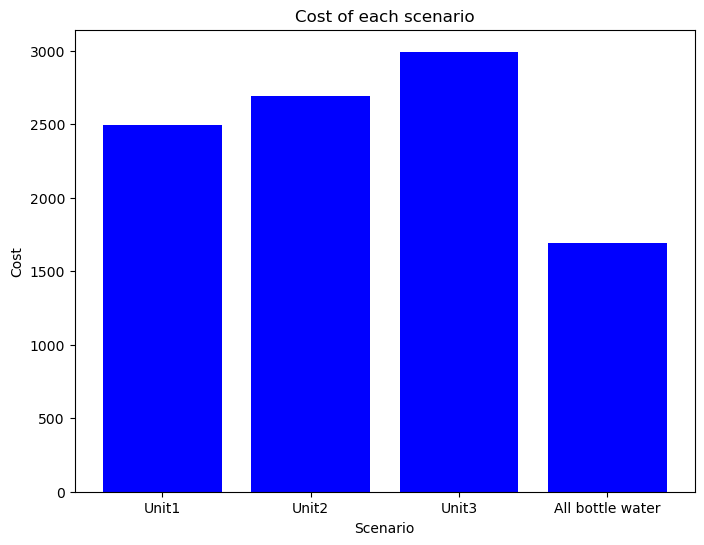

In [281]:
labels_4 = ['Unit1', 'Unit2', 'Unit3', 'All bottle water']

_, ax = plt.subplots(figsize=(8, 6))

ax.bar(range(4), cost_ls, color='blue')
ax.set(xticks=np.arange(4),
       xticklabels=labels_4,
       xlabel='Scenario',
       ylabel='Cost',
       title='Cost of each scenario')

plt.show()




In [282]:
print(
    f"The lowest cost of each scenario is ${np.min(cost_ls)},which is the \"{labels_4[np.argmin(cost_ls)]}\" scenario is prefered."
)


The lowest cost of each scenario is $1694.2,which is the "All bottle water" scenario is prefered.
